### Name: Weixuan (Ariel) Shao
### UNI: ws2652

# Part 1. Data Preparation

## exploratory data analysis

Value counts for HeavyRainfall-related columns:

   HeavyRainfall  HeavyRainfall_plus_1h  HeavyRainfall_plus_2h  \
0          87242                  87241                  87240   
1            430                    430                    430   

   HeavyRainfall_plus_3h  HeavyRainfall_Next3h  
0                  87239                 86553  
1                    430                  1119  


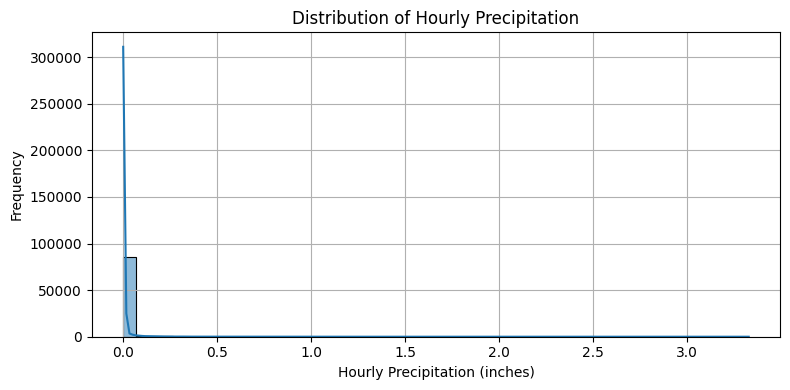

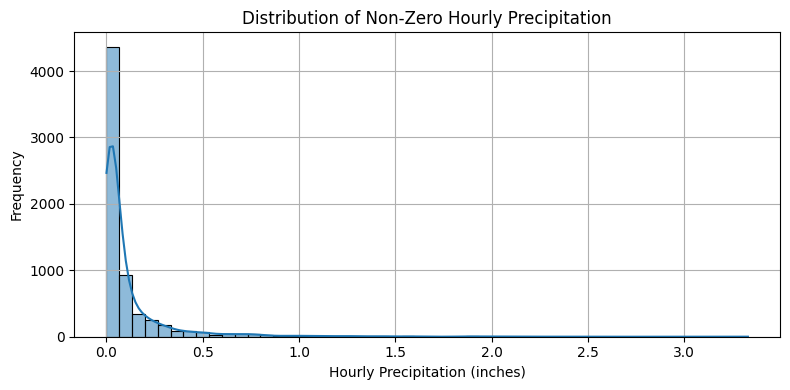


Percentage of rows labeled as Heavy Rainfall: 0.4905%


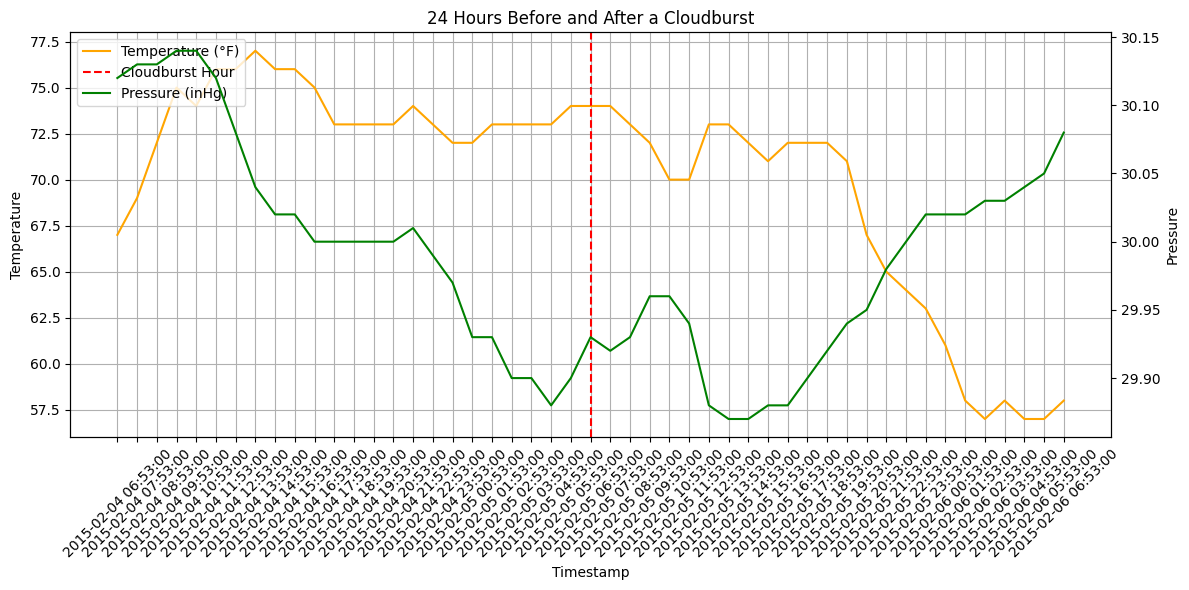

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv("hourly_data_complete.csv")

# --- Step 1: Verify labels ---
print("Value counts for HeavyRainfall-related columns:\n")
print(df[["HeavyRainfall", "HeavyRainfall_plus_1h", "HeavyRainfall_plus_2h",
          "HeavyRainfall_plus_3h", "HeavyRainfall_Next3h"]].apply(pd.Series.value_counts))

# --- Step 2: Distribution of Precipitation ---
plt.figure(figsize=(8, 4))
sns.histplot(df["HourlyPrecipitation"], bins=50, kde=True)
plt.title("Distribution of Hourly Precipitation")
plt.xlabel("Hourly Precipitation (inches)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Filter only non-zero precipitation values
nonzero_precip = df[df["HourlyPrecipitation"] > 0]["HourlyPrecipitation"]

# Plot histogram of non-zero values
plt.figure(figsize=(8, 4))
sns.histplot(nonzero_precip, bins=50, kde=True)
plt.title("Distribution of Non-Zero Hourly Precipitation")
plt.xlabel("Hourly Precipitation (inches)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate proportion of heavy rainfall
heavy_rain_pct = (df["HeavyRainfall"].sum() / len(df)) * 100
print(f"\nPercentage of rows labeled as Heavy Rainfall: {heavy_rain_pct:.4f}%")

# --- Step 3: Plot 24h before and after a cloudburst event with secondary y-axis for pressure ---

# Find the first index where a cloudburst happens (Next3h = 1)
cloudburst_idx = df[df["HeavyRainfall_Next3h"] == 1].index[0]

# Get 24h before and after (assuming 1 row = 1 hour)
window_df = df.iloc[cloudburst_idx - 24 : cloudburst_idx + 25].copy()

# Set up plot with secondary y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot precipitation and temperature on primary y-axis
ax1.plot(window_df["Unnamed: 0"], window_df["HourlyDryBulbTemperature"], label="Temperature (°F)", color="orange")
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Temperature")
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

# Mark cloudburst hour
ax1.axvline(x=window_df["Unnamed: 0"].iloc[24], color='red', linestyle='--', label='Cloudburst Hour')

# Create secondary y-axis for pressure
ax2 = ax1.twinx()
ax2.plot(window_df["Unnamed: 0"], window_df["HourlyStationPressure"], label="Pressure (inHg)", color="green")
ax2.set_ylabel("Pressure")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.title("24 Hours Before and After a Cloudburst")
plt.tight_layout()
plt.show()

# --- Step 4: Add week column ---
df["week"] = (df.index // (24 * 7)) + 1

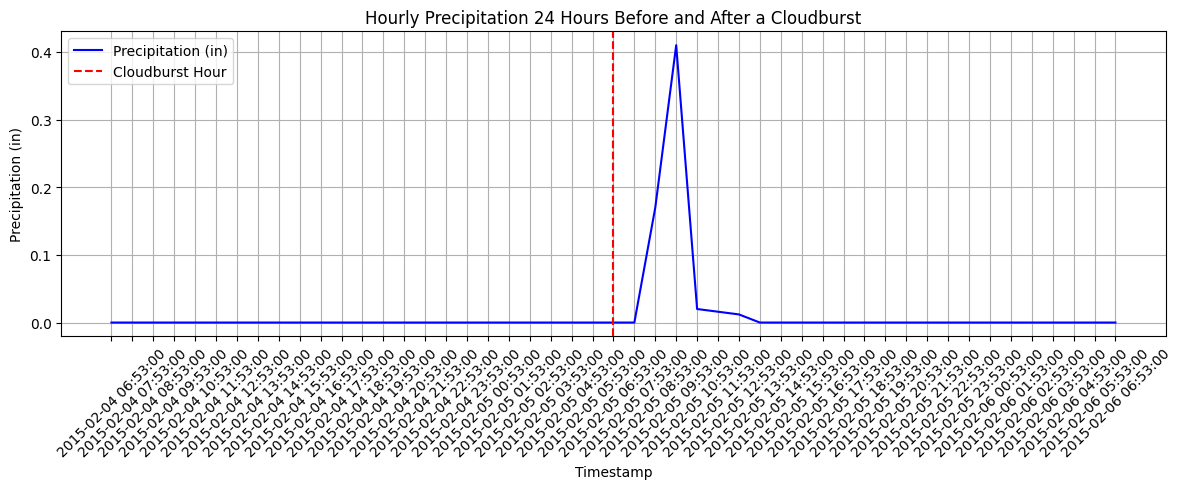

In [ ]:
import matplotlib.pyplot as plt

# Plot just the Hourly Precipitation trend around the cloudburst event
plt.figure(figsize=(12, 5))
plt.plot(window_df["Unnamed: 0"], window_df["HourlyPrecipitation"], color='blue', label="Precipitation (in)")

# Mark the cloudburst hour
plt.axvline(x=window_df["Unnamed: 0"].iloc[24], color='red', linestyle='--', label='Cloudburst Hour')

# Add labels and title
plt.xlabel("Timestamp")
plt.ylabel("Precipitation (in)")
plt.title("Hourly Precipitation 24 Hours Before and After a Cloudburst")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# 1. High Relative Humidity Indicator (RH > 90%)
df["HighHumidity"] = (df["HourlyRelativeHumidity"] > 90).astype(int)

# 2. Rainfall accumulation over last 3 hours
df["Rainfall_Last3h"] = df["HourlyPrecipitation"].rolling(window=3, min_periods=1).sum()

# 3. Change in pressure over the last 3 hours
df["Pressure_Change_3h"] = df["HourlyStationPressure"] - df["HourlyStationPressure"].shift(3)

# 4. Rainfall accumulation over last 24 hours
df["Rainfall_Last24h"] = df["HourlyPrecipitation"].rolling(window=24, min_periods=1).sum()

# check if the new columns are added
print(df[["HighHumidity", "Rainfall_Last3h", "Pressure_Change_3h", "Rainfall_Last24h"]].head(10))


   HighHumidity  Rainfall_Last3h  Pressure_Change_3h  Rainfall_Last24h
0             0              0.0                 NaN               0.0
1             0              0.0                 NaN               0.0
2             0              0.0                 NaN               0.0
3             0              0.0               -0.03               0.0
4             0              0.0               -0.02               0.0
5             0              0.0                0.02               0.0
6             1              0.0                0.05               0.0
7             1              0.0                0.06               0.0
8             0              0.0                0.05               0.0
9             0              0.0                0.04               0.0


In [ ]:
# Copy new features into the 24h window
window_df["HighHumidity"] = df.loc[window_df.index, "HighHumidity"]
window_df["Rainfall_Last3h"] = df.loc[window_df.index, "Rainfall_Last3h"]
window_df["Pressure_Change_3h"] = df.loc[window_df.index, "Pressure_Change_3h"]
window_df["Rainfall_Last24h"] = df.loc[window_df.index, "Rainfall_Last24h"]


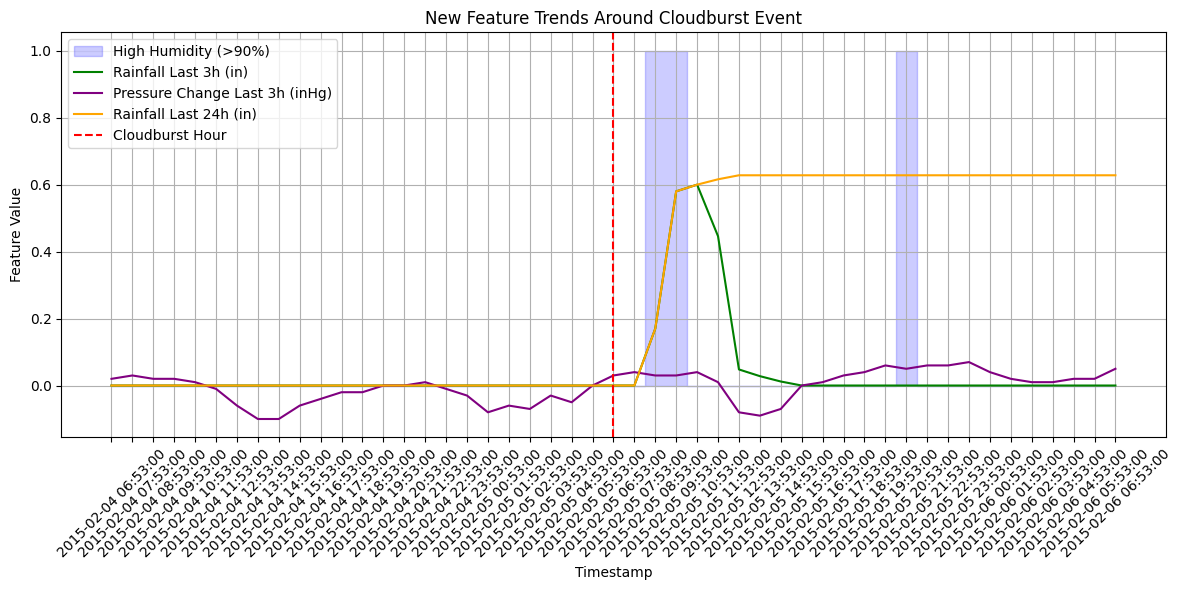

In [ ]:
# Create figure
plt.figure(figsize=(12, 6))

# Plot 1: HighHumidity (binary)
plt.fill_between(window_df["Unnamed: 0"], 0, window_df["HighHumidity"],
                 step="mid", alpha=0.2, label="High Humidity (>90%)", color='blue')

# Plot 2: Rainfall_Last3h
plt.plot(window_df["Unnamed: 0"], window_df["Rainfall_Last3h"], label="Rainfall Last 3h (in)", color='green')

# Plot 3: Pressure_Change_3h
plt.plot(window_df["Unnamed: 0"], window_df["Pressure_Change_3h"], label="Pressure Change Last 3h (inHg)", color='purple')

# Plot 4: Rainfall_Last24h
plt.plot(window_df["Unnamed: 0"], window_df["Rainfall_Last24h"], label="Rainfall Last 24h (in)", color='orange')

# Cloudburst marker
plt.axvline(x=window_df["Unnamed: 0"].iloc[24], color='red', linestyle='--', label='Cloudburst Hour')

# Formatting
plt.title("New Feature Trends Around Cloudburst Event")
plt.xlabel("Timestamp")
plt.ylabel("Feature Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Article Features

*Reflection question: Looking at the cloudburst events you identified in the dataset, what patterns did you observe in the meteorological variables leading up to these events that align with the physical mechanisms described in the article?*

1. High Relative Humidity:
The relative humidity exceeds 90% just after the cloudburst, not before. The atmosphere may have continued to saturate or experienced lingering high humidity following the initial rainfall burst, rather than showing a clear buildup beforehand. This does not fully align with the article's described mechanism of humidity-driven buildup before the cloudburst.

2. Sudden Pressure Drop:
A noticeable decline in atmospheric pressure occurred in the hours before the cloudburst. This aligns with the article’s description that a sudden drop in pressure can signal rising air and atmospheric instability—conditions favorable for intense, localized precipitation.

3. Sharp Rainfall Accumulation:
Both Rainfall_Last3h and Rainfall_Last24h features show rapid increases around the cloudburst, indicating a quick build-up of rainfall. This pattern reflects the article’s point that cloudbursts can follow periods of relatively dry weather, ending in sudden intense rain.

4. Temperature Fluctuation:
While not as dramatic as the other variables, there was a slight drop in temperature around the cloudburst hour. This may reflect evaporative cooling from precipitation or the movement of cooler, moisture-laden air masses—both of which are consistent with the cloudburst dynamics described in the article.

# 2. Random Forest

## Split data by week

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Get unique weeks
unique_weeks = df["week"].unique()

# Split weeks into training and testing (80% train, 20% test)
train_weeks, test_weeks = train_test_split(unique_weeks, test_size=0.2, random_state=42)

# Filter full dataset based on week assignment
train_df = df[df["week"].isin(train_weeks)].copy()
test_df = df[df["week"].isin(test_weeks)].copy()

# Confirm the split
print(f"Train weeks: {len(train_weeks)}, Test weeks: {len(test_weeks)}")
print(f"Train rows: {train_df.shape[0]}, Test rows: {test_df.shape[0]}")

Train weeks: 417, Test weeks: 105
Train rows: 70056, Test rows: 17616


## Address Class Imbalance

In [ ]:
# Filter training data to only include rows where there is some precipitation
weeks_with_rain = train_df.groupby("week")["HourlyPrecipitation"].sum()
rainy_weeks = weeks_with_rain[weeks_with_rain > 0].index

# Filter train_df to only include these rainy weeks
train_df = train_df[train_df["week"].isin(rainy_weeks)].copy()

# Confirm how many rows remain
print(f"Filtered training weeks (with rain): {len(rainy_weeks)}")
print(f"Filtered training rows: {train_df.shape[0]}")

Filtered training weeks (with rain): 387
Filtered training rows: 65016


Confusion Matrix:
 [[17347     4]
 [  225     3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     17351
           1       0.43      0.01      0.03       228

    accuracy                           0.99     17579
   macro avg       0.71      0.51      0.51     17579
weighted avg       0.98      0.99      0.98     17579



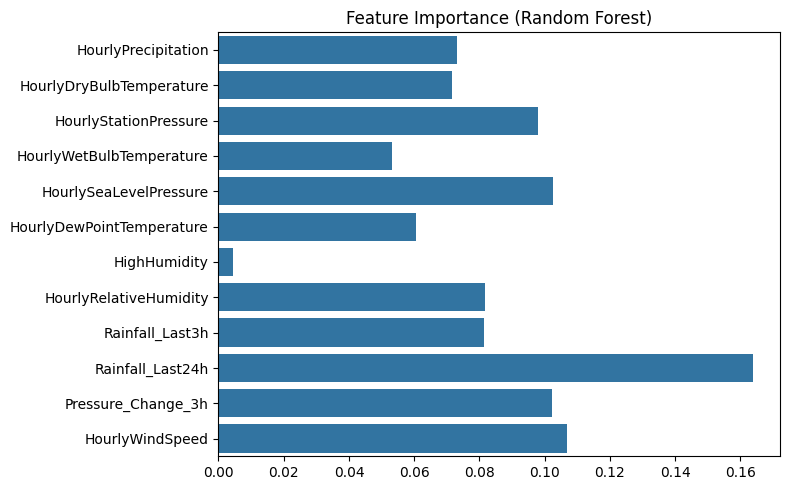

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Features to use
features = [
    "HourlyPrecipitation", "HourlyDryBulbTemperature", "HourlyStationPressure", "HourlyWetBulbTemperature", "HourlySeaLevelPressure", "HourlyDewPointTemperature",
    "HighHumidity", "HourlyRelativeHumidity", "Rainfall_Last3h", "Rainfall_Last24h", "Pressure_Change_3h", "HourlyWindSpeed"
]
target = "HeavyRainfall_Next3h"

# Drop rows with any missing values in selected features
train_data = train_df.dropna(subset=features + [target])
test_data = test_df.dropna(subset=features + [target])

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_data[features], train_data[target])

# Predict and evaluate
y_pred = rf_model.predict(test_data[features])
y_true = test_data[target]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot feature importance
importances = rf_model.feature_importances_
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

In [ ]:
# Create interaction features in train and test sets
train_df["Humidity_Temp"] = train_df["HighHumidity"] * train_df["HourlyDryBulbTemperature"]
train_df["Wind_Pressure"] = train_df["HourlyWindSpeed"] * train_df["HourlyStationPressure"]
train_df["Rain_Temp"] = train_df["Rainfall_Last3h"] * train_df["HourlyDryBulbTemperature"]
train_df["Dew_Wet"] = train_df["HourlyDewPointTemperature"] * train_df["HourlyWetBulbTemperature"]

# Apply same interaction terms to test set
test_df["Humidity_Temp"] = test_df["HighHumidity"] * test_df["HourlyDryBulbTemperature"]
test_df["Wind_Pressure"] = test_df["HourlyWindSpeed"] * test_df["HourlyStationPressure"]
test_df["Rain_Temp"] = test_df["Rainfall_Last3h"] * test_df["HourlyDryBulbTemperature"]
test_df["Dew_Wet"] = test_df["HourlyDewPointTemperature"] * test_df["HourlyWetBulbTemperature"]

In [ ]:
# Final feature set including interaction terms
features = [
    "HourlyPrecipitation", "HourlyDryBulbTemperature", "HourlyStationPressure",
    "HourlySeaLevelPressure", "HourlyWindSpeed", "HourlyWetBulbTemperature",
    "HourlyDewPointTemperature", "HourlyRelativeHumidity", "HighHumidity",
    "Rainfall_Last3h", "Rainfall_Last24h", "Pressure_Change_3h",
    "Humidity_Temp", "Wind_Pressure", "Rain_Temp", "Dew_Wet"
]

target = "HeavyRainfall_Next3h"

Confusion Matrix:
[[17381     7]
 [  226     2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17388
           1       0.22      0.01      0.02       228

    accuracy                           0.99     17616
   macro avg       0.60      0.50      0.51     17616
weighted avg       0.98      0.99      0.98     17616



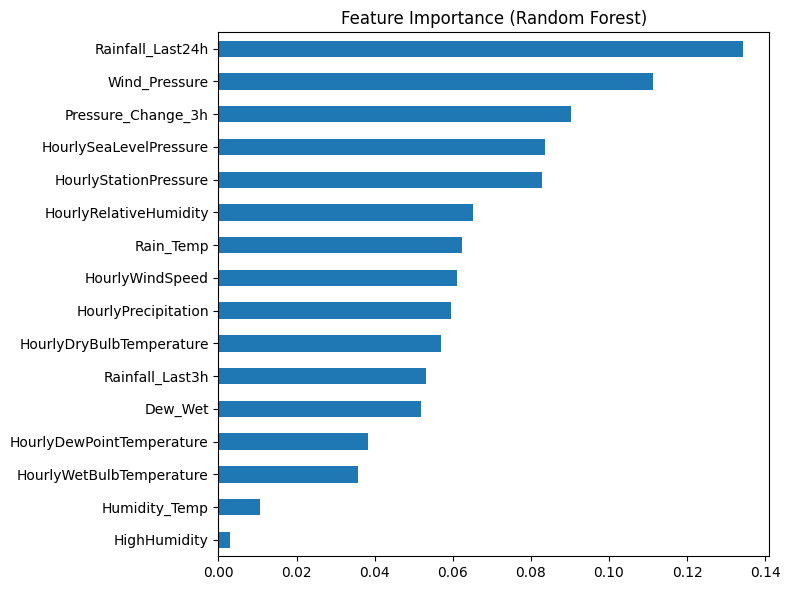

In [ ]:
# Select features and target
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importances plot
importances = rf_model.feature_importances_
feat_names = X_train.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values()

plt.figure(figsize=(8, 6))
feat_imp.plot(kind="barh")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

Confusion Matrix:
[[17384     4]
 [  225     3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17388
           1       0.43      0.01      0.03       228

    accuracy                           0.99     17616
   macro avg       0.71      0.51      0.51     17616
weighted avg       0.98      0.99      0.98     17616



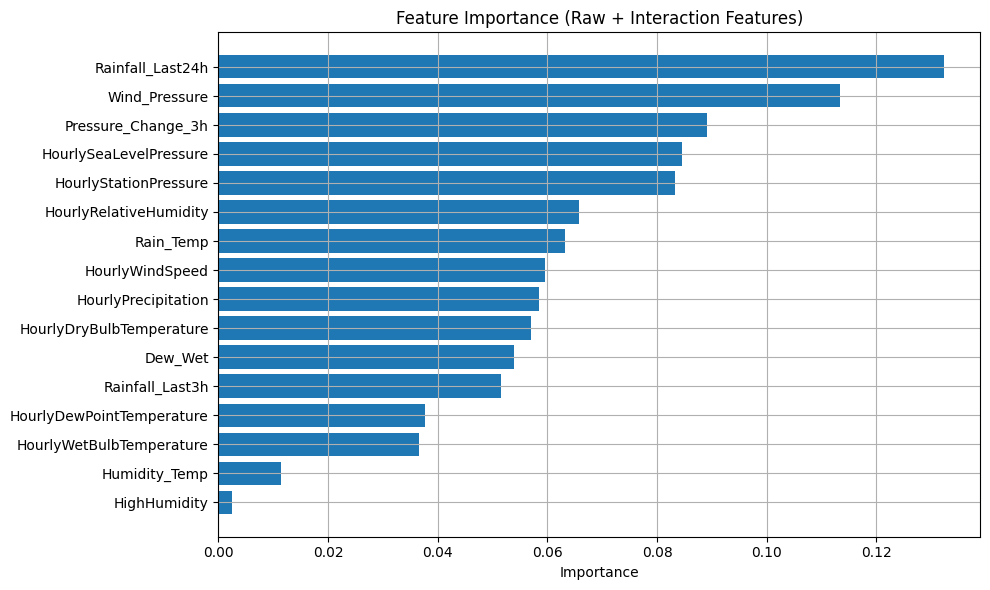

In [ ]:
# Feature Set: Combined raw + interaction features
features_set3 = [
    "HourlyPrecipitation", "HourlyDryBulbTemperature", "HourlyStationPressure",
    "HourlyWetBulbTemperature", "HourlySeaLevelPressure", "HourlyDewPointTemperature",
    "HourlyRelativeHumidity", "HourlyWindSpeed", "Rainfall_Last3h",
    "Rainfall_Last24h", "Pressure_Change_3h", "HighHumidity",
    "Humidity_Temp", "Rain_Temp", "Wind_Pressure", "Dew_Wet"
]

# Target remains the same
target = "HeavyRainfall_Next3h"

# Prepare train/test sets
X_train = train_df[features_set3]
X_test = test_df[features_set3]
y_train = train_df[target]
y_test = test_df[target]

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance plot
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": features_set3,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Importance")
plt.title("Feature Importance (Raw + Interaction Features)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

*Reflection question: When you split the data by weeks rather than randomly, how did this affect your model's performance compared to what you might have expected with random splitting? What does this tell you about weather data and working with time series?*

When I split the data by weeks rather than randomly, the model’s overall accuracy remained high (99%), but it’s heavily biased by class imbalance. The performance on cloudburst prediction was poor — particularly in recall, which was close to zero. Even in my best attempt, precision for cloudbursts reached 43%, but recall stayed low, meaning the model detected very few of the actual events.

This performance is likely more realistic than what I might have observed with random splitting. Random splitting could have led to data leakage, with similar weather patterns appearing in both train and test sets, artificially boosting performance metrics like precision, recall, and F1-score.

This reveals an important aspect of working with weather time series: conditions are temporally autocorrelated, and models need to be evaluated on entirely unseen time blocks to simulate real-world forecasting. Cluster sampling by week respects that structure and gives a more honest view of generalizability.

# 3. Dry Period Duration

In [ ]:
# Step 1: Create an array to store hours since last rain
hours_since_rain = []
counter = 0

# Step 2: Loop through the hourly data
for precip in df["HourlyPrecipitation"]:
    if precip > 0:
        counter = 0  # Reset when there's precipitation
    else:
        counter += 1  # Count dry hours
    hours_since_rain.append(counter)

# Step 3: Assign and log-transform
df["Hours_Since_Rain"] = hours_since_rain
df["DryPeriod_Log"] = np.log1p(df["Hours_Since_Rain"])  # log(1 + hours)

# Check the first few rows
df[["HourlyPrecipitation", "Hours_Since_Rain", "DryPeriod_Log"]].head(10)

,HourlyPrecipitation,Hours_Since_Rain,DryPeriod_Log
0,0.0,1,0.693147
1,0.0,2,1.098612
2,0.0,3,1.386294
3,0.0,4,1.609438
4,0.0,5,1.791759
5,0.0,6,1.945910
6,0.0,7,2.079442
7,0.0,8,2.197225
8,0.0,9,2.302585
9,0.0,10,2.397895


Confusion Matrix:
 [[17386     2]
 [  227     1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     17388
           1       0.33      0.00      0.01       228

    accuracy                           0.99     17616
   macro avg       0.66      0.50      0.50     17616
weighted avg       0.98      0.99      0.98     17616



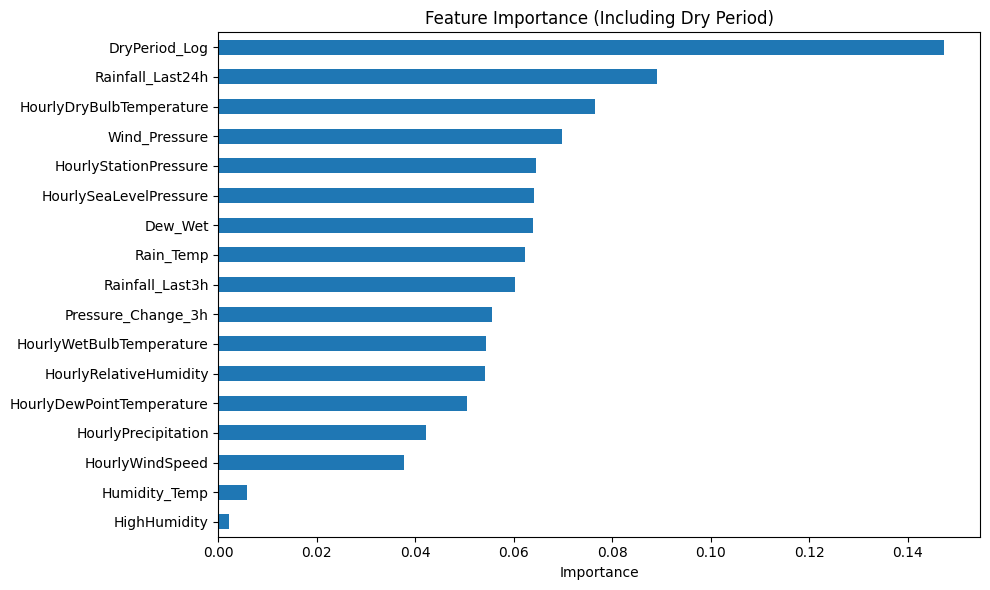

In [ ]:
# Copy the DryPeriod_Log column into train and test DataFrames
train_df["DryPeriod_Log"] = df.loc[train_df.index, "DryPeriod_Log"]
test_df["DryPeriod_Log"] = df.loc[test_df.index, "DryPeriod_Log"]

# Updated feature list with DryPeriod_Log
features = [
    "HourlyPrecipitation", "HourlyDryBulbTemperature", "HourlyStationPressure",
    "HourlyRelativeHumidity", "HourlyDewPointTemperature", "HourlyWetBulbTemperature",
    "HourlySeaLevelPressure", "HourlyWindSpeed", "HighHumidity",
    "Rainfall_Last3h", "Rainfall_Last24h", "Pressure_Change_3h",
    # Interaction features
    "Wind_Pressure", "Rain_Temp", "Dew_Wet", "Humidity_Temp",
    # New feature
    "DryPeriod_Log"
]

target = "HeavyRainfall_Next3h"

# Prepare training and testing data
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Train model with class_weight='balanced'
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot feature importance
import matplotlib.pyplot as plt
import pandas as pd

importances = rf_model.feature_importances_
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_importance.plot(kind='barh')
plt.title("Feature Importance (Including Dry Period)")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

Despite DryPeriod_Log being the most important feature by importance ranking, the model's cloudburst detection performance slightly declined in terms of precision and recall.

*Reflection question: What have you learned about time series data modeling and feature engineering through this assignment?*

I learned that working with time series weather data requires careful attention to the temporal structure of the data. Random splits can overestimate performance, so using week-based splits gave me a more realistic sense of how a model would perform in practice. I also saw how meaningful feature engineering—like tracking dry periods, pressure changes, and recent rainfall—can bring valuable context and influence model behavior. But even with well-designed features, class imbalance and the rarity of extreme weather events like cloudbursts remain major challenges that require strategies to address.